In [1]:
from catinous.dataset import BatchDataset, ContinuousDataset
from catinous.dynamicmemory.DynamicMemoryModel import DynamicMemoryModel 
import catinous.dynamicmemory.DynamicMemoryModel as dmodel
import catinous.utils as cutils
import os
import pandas as pd
from py_jotools import mut, slurm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
#import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from catinous.dataset.ContinuousDataset import *
from catinous.dataset.BatchDataset import *
from torch.utils.data import DataLoader


In [5]:
def ap_model_seeds(hparams, seed=2314134, split='test'):
    recalls = {'ges': [], 'geb': [], 'sie': []}
    precision = {'ges': [], 'geb': [], 'sie': []}
    
    hparams['seed'] = seed

    model, logs, df_mem, expname = lungmodel.trained_model(hparams, train=False)
    model.eval()

    for res in ['ges', 'geb', 'sie']:
        ds_test = LIDCDataset('/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv', 
                      cropped_to=(288, 288), split=[split], res=res, validation=True)

        device = torch.device('cuda')
        iou_thres = 0.5

        overall_true_pos = dict()
        overall_false_pos = dict()
        overall_false_neg = dict()
        overall_boxes_count = dict()
        for k in np.arange(0.0, 1.01, 0.05):
            overall_true_pos[k] = 0
            overall_false_pos[k] = 0
            overall_false_neg[k] = 0
            overall_boxes_count[k] = 0
            

        for batch in ds_test:
            img_batch, annot, res, image = batch
            img_batch = img_batch.to(device)

            out = model.model(img_batch)
            out_boxes = [cutils.filter_boxes_area(out[i]['boxes'].cpu().detach().numpy(), out[i]['scores'].cpu().detach().numpy()) for i in range(len(out))]
            boxes_np = [b[0] for b in out_boxes]
            scores_np = [b[1] for b in out_boxes]

            final_boxes, final_scores = cutils.correct_boxes(boxes_np, scores_np)

            gt = annot['boxes'][0]
            for k in np.arange(0.0, 1.01, 0.05):
                false_positives = 0
                false_negatives = 0
                true_positives = 0
                detected = False
                boxes_count = 0
                if len(final_boxes)>0:
                    for i, b in enumerate(final_boxes):
                        if final_scores[i]>k:
                            boxes_count += 1
                            if cutils.bb_intersection_over_union(gt, b)>iou_thres:
                                detected = True
                            else:
                                false_positives += 1
                    if detected:
                        true_positives += 1
                    else:
                        false_negatives += 1
                overall_true_pos[k] += true_positives
                overall_false_pos[k] += false_positives
                overall_false_neg[k] += false_negatives
                overall_boxes_count[k] += boxes_count
        for k in np.arange(0.0, 1.01, 0.05):
            if (overall_false_neg[k]+overall_true_pos[k])==0:
                recalls[res].append(0.0)
            else:
                recalls[res].append(overall_true_pos[k]/(overall_false_neg[k]+overall_true_pos[k]))
            if (overall_false_pos[k]+overall_true_pos[k])==0:
                precision[res].append(0.0)
            else:
                precision[res].append(overall_true_pos[k]/(overall_false_pos[k]+overall_true_pos[k]))
    return recalls, precision

def get_ap_for_res(hparams, seed=2314134, split='test'):
    recalls, precision = ap_model_seeds(hparams, seed, split)
    
    aps = dict()
    for res in ['ges', 'geb', 'sie']:
        prec = np.array(precisions[res])
        rec = np.array(recalls[res])
        ap = []
        for t in np.arange(0.0, 1.01, 0.1):
            prec_arr = prec[rec>t]
            if len(prec_arr)==0:
                ap.append(0.0)
            else:
                ap.append(prec_arr.max())
        aps[res] = np.array(ap).mean()
    return aps

In [2]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv',
    'batch_size': 8,
    'training_batch_size': 8,
    'task': 'lidc',
    'model': 'rnn',
    'scanner': 'time_siemens',
     'noncontinuous_steps': 1000,
    'noncontinuous_train_splits': ['base', 'train'],
    'order': ['ges', 'geb', 'sie', 'time_siemens'],
    'use_memory': False
}
hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

print(hparams)
#print(cutils.get_expname(hparams))

model, _, _, _ = dmodel.trained_model(hparams, training=False)

{'root_dir': '/project/catinous/', 'datasetfile': '/project/catinous/lungnodulesfinalpatientsplit.csv', 'batch_size': 8, 'training_batch_size': 8, 'transition_phase_after': 0.8, 'memorymaximum': 128, 'use_memory': False, 'random_memory': True, 'balance_memory': False, 'order': ['ges', 'geb', 'sie', 'time_siemens'], 'continuous': False, 'noncontinuous_steps': 1000, 'noncontinuous_train_splits': ['base', 'train'], 'val_check_interval': 100, 'base_model': None, 'run_postfix': 1, 'gram_weights': None, 'dim': 2, 'task': 'lidc', 'model': 'rnn', 'scanner': 'time_siemens'}
lidc_batch_lungnodulesfinalpatientsplit_base-train_1_55d1c88136
Read: /project/catinous/trained_models/lidc_batch_lungnodulesfinalpatientsplit_base-train_1_55d1c88136.pt


AttributeError: 'NoneType' object has no attribute 'hparams'

In [2]:
modelpath = '/project/catinous/trained_models/lidc_batch_lungnodulesfinalpatientsplit_base-train_1_2be2b6a25e.pt'
num_classes = 3  # 0=background, 1=begnin, 2=malignant
# load a model pre-trained pre-trained on COCO
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

state_dict = torch.load(modelpath)
new_state_dict = {}
for key in state_dict.keys():
    new_state_dict[key.replace('model.', '')] = state_dict[key]
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [3]:
dl_val = DataLoader(LIDCBatch('/project/catinous/lungnodulesfinal.csv',
                                      split='val', res='time_siemens', validation=True),
                      batch_size=8,
                      num_workers=2,
                      collate_fn=cutils.collate_fn,
                       shuffle=False)

In [4]:
device = torch.device('cuda')
model.to(device)
model.eval()

for batch in dl_val:
    x, y, scanner, filepath = batch
    x = list(i.to(device) for i in x)
    #targets = [{k: v.to(self.device) for k, v in t.items()} for t in y]
    
    out = model(x)
    break    

/home/mperkonigg/venv_test/venv/local/lib/python3.6/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [ ]:
y

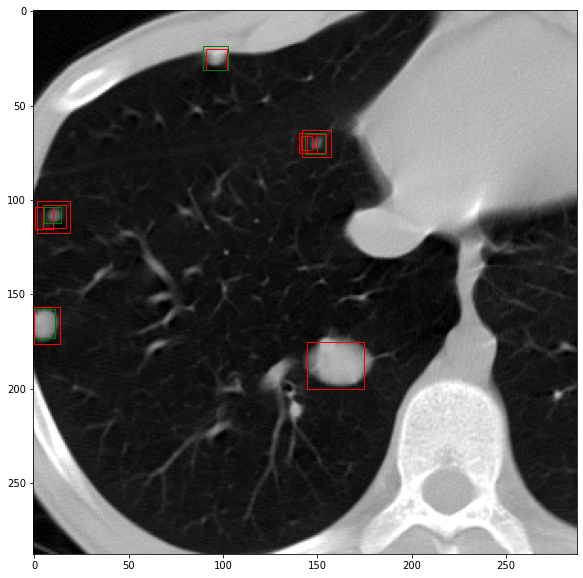

In [11]:
idx = 4

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xywh = [[ab[0], ab[1], ab[2] - ab[0], ab[3] - ab[1]] for ab in out[idx]['boxes']]

ax.imshow(x[idx].detach().cpu().numpy()[0])
#plt.scatter([x], [y])
for k, xy in enumerate(xywh):
    rect = patches.Rectangle((xy[0],xy[1]),xy[2],xy[3],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
for gt in y[idx]['boxes']:
    rect = patches.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], edgecolor='g', facecolor='none')
    ax.add_patch(rect)

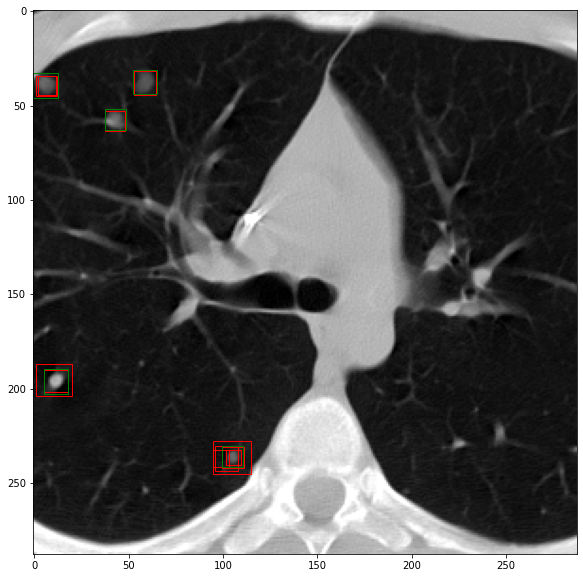

In [8]:
idx = 5

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xywh = [[ab[0], ab[1], ab[2] - ab[0], ab[3] - ab[1]] for ab in out[idx]['boxes']]

ax.imshow(x[idx].detach().cpu().numpy()[0])
#plt.scatter([x], [y])
for k, xy in enumerate(xywh):
    rect = patches.Rectangle((xy[0],xy[1]),xy[2],xy[3],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
for gt in y[idx]['boxes']:
    rect = patches.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], edgecolor='g', facecolor='none')
    ax.add_patch(rect)

In [5]:
filepath

('/data/dataset/external/LungTIME/PND024/1.3.12.2.1107.5.99.2.1315.4.0.1802470019911853/CT.2186.038',
 '/data/dataset/external/LungTIME/PND024/1.3.12.2.1107.5.99.2.1315.4.0.1802470019911853/CT.2186.082',
 '/data/dataset/external/LungTIME/PND051/1.3.12.2.1107.5.99.2.1315.4.0.1927717421633125/CT.2313.199',
 '/data/dataset/external/LungTIME/PND051/1.3.12.2.1107.5.99.2.1315.4.0.1927717421633125/CT.2313.140',
 '/data/dataset/external/LungTIME/PND051/1.3.12.2.1107.5.99.2.1315.4.0.1927717421633125/CT.2313.206',
 '/data/dataset/external/LungTIME/PND051/1.3.12.2.1107.5.99.2.1315.4.0.1926838117881397/CT.2313.100',
 '/data/dataset/external/LungTIME/PND051/1.3.12.2.1107.5.99.2.1315.4.0.1926838117881397/CT.2313.060',
 '/data/dataset/external/LungTIME/PND051/1.3.12.2.1107.5.99.2.1315.4.0.1927717421633125/CT.2313.149')

In [6]:
y

({'boxes': tensor([[ 90.3819, 231.4843, 102.3819, 243.4843],
          [ 90.3819, 231.4843, 102.3819, 243.4843]]),
  'labels': tensor([2]),
  'image_id': tensor([0]),
  'area': tensor([144., 144.], dtype=torch.float64),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[  5.0000, 114.5509,  14.0000, 123.5509],
          [  5.0000, 114.5509,  14.0000, 123.5509]]),
  'labels': tensor([2]),
  'image_id': tensor([1]),
  'area': tensor([81., 81.], dtype=torch.float64),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[ 271.0000,  208.0657,  283.0000,  220.0657],
          [ 271.0000,  208.0657,  283.0000,  220.0657],
          [ -52.1778,   48.6991,  -43.1778,   57.6991],
          [-136.4930,  157.7716, -121.4930,  172.7716],
          [ -43.1338,   19.0103,  -30.1338,   32.0103],
          [   9.7459,   64.3160,   20.7459,   75.3160]]),
  'labels': tensor([2]),
  'image_id': tensor([2]),
  'area': tensor([144.0000, 144.0000,  81.0000, 225.0000, 169.0000, 121.0000],
         dtype=torch.float64),

In [18]:
df = pd.read_csv('/project/catinous/lungnodulesfinal.csv')
df_val = df.loc[df.split=='val']
df_val = df_val.loc[df_val.dataset=='time']

In [19]:
df_val.groupby('patient_id').count()

,dataset,scanner,image,x1,x2,y1,y2,bin_malignancy,split
patient_id,,,,,,,,,
PND024,2,2,2,2,2,2,2,2,2
PND051,7,7,7,7,7,7,7,7,7
PND060,4,4,4,4,4,4,4,4,4
PND075,1,1,1,1,1,1,1,1,1
PND100,1,1,1,1,1,1,1,1,1
PND101,2,2,2,2,2,2,2,2,2
PND105,1,1,1,1,1,1,1,1,1
PND109,1,1,1,1,1,1,1,1,1
PND112,2,2,2,2,2,2,2,2,2


In [21]:
df_val.loc[df_val.patient_id=='PND060']

,dataset,scanner,patient_id,image,x1,x2,y1,y2,bin_malignancy,split
875,time,time_siemens,PND060,/data/dataset/external/LungTIME/PND060/1.3.12....,360.651828,374.651828,142.910256,156.910256,1,val
877,time,time_siemens,PND060,/data/dataset/external/LungTIME/PND060/1.3.12....,341.764958,355.764958,193.235042,207.235042,1,val
894,time,time_siemens,PND060,/data/dataset/external/LungTIME/PND060/1.3.12....,68.072650,78.072650,369.183760,379.183760,1,val
904,time,time_siemens,PND060,/data/dataset/external/LungTIME/PND060/1.3.12....,446.102564,457.102564,262.017094,273.017094,1,val


In [24]:
df_val.sort_values('patient_id').reset_index(drop=True)

,dataset,scanner,patient_id,image,x1,x2,y1,y2,bin_malignancy,split
0,time,time_siemens,PND024,/data/dataset/external/LungTIME/PND024/1.3.12....,202.381890,214.381890,343.484252,355.484252,1,val
1,time,time_siemens,PND024,/data/dataset/external/LungTIME/PND024/1.3.12....,87.309866,96.309866,226.550950,235.550950,1,val
2,time,time_siemens,PND051,/data/dataset/external/LungTIME/PND051/1.3.12....,439.718472,451.718472,320.065726,332.065726,1,val
3,time,time_siemens,PND051,/data/dataset/external/LungTIME/PND051/1.3.12....,134.339192,145.339192,337.406962,348.406962,1,val
4,time,time_siemens,PND051,/data/dataset/external/LungTIME/PND051/1.3.12....,40.961482,49.961482,215.506564,224.506564,1,val
5,time,time_siemens,PND051,/data/dataset/external/LungTIME/PND051/1.3.12....,103.144996,116.144996,301.648004,314.648004,1,val
6,time,time_siemens,PND051,/data/dataset/external/LungTIME/PND051/1.3.12....,82.997510,94.997510,242.200804,254.200804,1,val
7,time,time_siemens,PND051,/data/dataset/external/LungTIME/PND051/1.3.12....,83.796358,91.796358,290.397870,298.397870,1,val
8,time,time_siemens,PND051,/data/dataset/external/LungTIME/PND051/1.3.12....,171.292570,185.292570,196.396544,210.396544,1,val
9,time,time_siemens,PND060,/data/dataset/external/LungTIME/PND060/1.3.12....,360.651828,374.651828,142.910256,156.910256,1,val
